# Compare topic sentiment with CBS sentiment

In [106]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import re

In [2]:
PATTERNSENTIMENTFILE = "../data/sentiment/corona|covid|flattenthecurve|blijfthuis|rivm|mondkapje|huisarts|houvol.csv"
CBSSENTIMENTFILE = "sentiment-cbs.csv"
SENTIMENT = "sentiment"
COUNT = "count"

In [6]:
def makeSentimentPerDay(sentimentPerHour):
    sentimentPerDay = {}
    for hour in sentimentPerHour.index:
        day = re.sub("..$","12",hour)
        if not day in sentimentPerDay: sentimentPerDay[day] = {SENTIMENT:0,COUNT:0}
        sentimentPerDay[day][SENTIMENT] += sentimentPerHour.loc[hour][SENTIMENT]*sentimentPerHour.loc[hour][COUNT]
        sentimentPerDay[day][COUNT] += sentimentPerHour.loc[hour][COUNT]
    for day in sentimentPerDay:
        sentimentPerDay[day][SENTIMENT] /= sentimentPerDay[day][COUNT]
    return(sentimentPerDay)

In [ ]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [94]:
DATEFORMATHOUR = "%Y%m%d-%H"
DATEFORMATMONTH = "%-d/%-m"
DEFAULTTITLE = "Sentiment"
DATA = "data"
LABEL = "label"
HIGHLIGHT = "highlight"
COMBINEDDAYS = 7

def visualizeSentiment(dataSources,title=DEFAULTTITLE,dateFormat=DATEFORMATMONTH):
    font = {"size":14}
    matplotlib.rc("font",**font)
    fig,ax = plt.subplots(figsize=(12,6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter(dateFormat))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        lineData= ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in data],\
                     movingAverage([data[key][SENTIMENT] for key in data],COMBINEDDAYS),xdate=True,fmt="-",label=label)
        if HIGHLIGHT in dataSources[i]:
            highlight = dataSources[i][HIGHLIGHT]
            highlightlabel = dataSources[i][HIGHLIGHTLABEL]
            color = lineData[-1].get_color()
            ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in highlight],
                         [data[key][SENTIMENT] for key in highlight],\
                         fmt="o",color=color,label=highlightlabel)
                
    plt.title(title)
    plt.legend(framealpha=0.2)
    plt.show()
    return(ax)

In [113]:
patternSentimentDfHour = pd.read_csv(PATTERNSENTIMENTFILE,index_col="date")
cbsSentimentDf = pd.read_csv(CBSSENTIMENTFILE,index_col="date")

In [114]:
YEAR = "2020"
HOUR = "12"
QUOTIENTFACTOR = 11
ADDITIONFACTOR = 0.065

def convertDate(shortDate):
    day,month = shortDate.split("-")
    return(YEAR+month+day+"-"+HOUR)

cbsSentimentDict = {}
for shortDate in cbsSentimentDf.index: 
    longDate = convertDate(shortDate)
    cbsSentimentDict[longDate] = {SENTIMENT:cbsSentimentDf.loc[str(shortDate)][SENTIMENT]/QUOTIENTFACTOR+ADDITIONFACTOR}

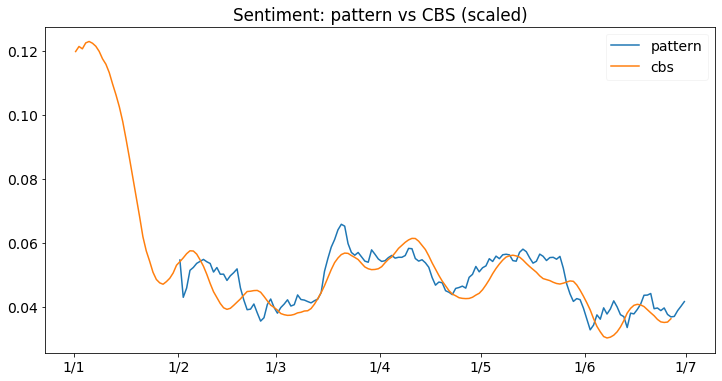

In [115]:
patternSentimentDictDay = makeSentimentPerDay(patternSentimentDfHour)
dummy = visualizeSentiment([{DATA:patternSentimentDictDay,LABEL:"pattern"},{DATA:cbsSentimentDict,LABEL:"cbs"}],\
                           title="Sentiment: pattern vs CBS (scaled)")

Text(0.5, 1.0, 'Sentiment: pattern vs CBS (scaled)')

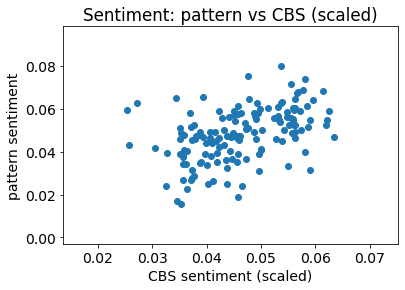

In [117]:
plt.scatter([cbsSentimentDict[key][SENTIMENT] for key in patternSentimentDictDay if key in cbsSentimentDict],\
            [patternSentimentDictDay[key][SENTIMENT] for key in patternSentimentDictDay if key in cbsSentimentDict])
plt.xlabel("CBS sentiment (scaled)")
dummy = plt.ylabel("pattern sentiment")
plt.title("Sentiment: pattern vs CBS (scaled)")

In [119]:
np.corrcoef([cbsSentimentDict[key][SENTIMENT] for key in patternSentimentDictDay if key in cbsSentimentDict],\
            [patternSentimentDictDay[key][SENTIMENT] for key in patternSentimentDictDay if key in cbsSentimentDict])[0][1]

0.4636318308242617